In [347]:
import os
import torch
import os
import torchvision.models as models
import torch.nn as nn
from deepproblog.dataset import Dataset, DataLoader
from torch.utils.data import Dataset as TorchDataset
from problog.logic import Term, Constant, Var, list2term
from deepproblog.dataset import ImageDataset
from deepproblog.evaluate import get_confusion_matrix

import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from deepproblog.utils.stop_condition import EpochStop
from deepproblog.optimizer import SGD

from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.engines import ExactEngine
from deepproblog.query import Query
from deepproblog.train import train_model
from deepface import DeepFace
import torch.nn as nn
import torch.nn.functional as F


In [348]:
# GLOBAL VARS
training_size = None
epochs = 2
batch_size = 2
lr_faces = 0.0001
lr_scene = 0.0001
lr_model = 3e-3

clean_df = False

In [349]:
# Directories
script_dir = os.getcwd()
print("script_dir:", script_dir)
base_dir = os.path.dirname(os.path.dirname(script_dir))
print("base_dir:", base_dir)
prolog_dir = os.path.join(base_dir, "prolog")
data_dir = os.path.join(base_dir, "data")
print("data_dir:", data_dir)
findingemo_dir = os.path.join(data_dir, "FindingEmo_Images")
print("findingemo_dir:", findingemo_dir)
prolog_dir = os.path.join(base_dir, "code", "prolog")
print("prolog_dir:", prolog_dir)
if clean_df:
    df = pd.read_csv(os.path.join(findingemo_dir, "annotations_single.ann"))
else:
    df = pd.read_pickle(os.path.join(script_dir, "clean_findingemo.pkl"))

script_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\notebooks
base_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition
data_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data
findingemo_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images
prolog_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\prolog


In [350]:
# try to read all the images to see if any are missing or corrupted
if clean_df:

    # Delete the columns: "user" and "index" and "datetime"
    if "user" in df.columns and "index" in df.columns and "datetime" in df.columns:
        df = df.drop(columns=["user", "index", "datetime"])

    # remove leading slash from image_path
    if df["image_path"].iloc[0].startswith("/"):
        df["image_path"] = df["image_path"].str.lstrip("/")

    # in the dataframe image_path column, change all the occurences of 'lmertens' to 'anon'
    df["image_path"] = df["image_path"].str.replace("lmertens", "anon", regex=False)
    # change the occurences of *, : ? in the image_path to _
    df["image_path"] = df["image_path"].str.replace("*", "_", regex=False)
    df["image_path"] = df["image_path"].str.replace(":", "_", regex=False)
    df["image_path"] = df["image_path"].str.replace("?", "_", regex=False)
    
    corrupted_indices = []
    for idx, row in df.iterrows():
        if idx % 100 == 0:
            print(f"Checking image {idx}/{len(df)}")
        img_path = os.path.join(findingemo_dir, row['image_path'])
        try:
            img = cv2.imread(img_path)
            if img is None:
                print(f"Image at index {idx} could not be read: {img_path}")
                corrupted_indices.append(idx)
        except Exception as e:
            print(f"Error reading image at index {idx}: {img_path}. Error: {e}")
    print(f"Total corrupted/missing images: {len(corrupted_indices)}")
    print("Corrupted indices:", corrupted_indices)
    # Remove corrupted entries from dataframe
    df = df.drop(index=corrupted_indices).reset_index(drop=True)
    # save the cleaned dataframe as pickle
    df.to_pickle("clean_findingemo.pkl")

In [351]:
# corrupted_indices = []
# for idx, row in df.iterrows():
#     if idx % 100 == 0:
#         print(f"Checking image {idx}/{len(df)}")
#     img_path = os.path.join(findingemo_dir, row['image_path'])
#     try:
#         img = cv2.imread(img_path)
#         if img is None:
#             print(f"Image at index {idx} could not be read: {img_path}")
#             corrupted_indices.append(idx)
#     except Exception as e:
#         print(f"Error reading image at index {idx}: {img_path}. Error: {e}")
# print(f"Total corrupted/missing images: {len(corrupted_indices)}")
# print("Corrupted indices:", corrupted_indices)

In [352]:
# set device, move models and maps, set eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [353]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,Trust,"BodyLanguage,FacialExpression",0
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,Interest,FacialExpression,0
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,Interest,BodyLanguage,3
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,Interest,"BodyLanguage,FacialExpression",4
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,Apprehension,ConflictCtxtPerson,0


In [354]:
# Load category names
scene_categories_path = os.path.join(data_dir, "places365/categories_places365.txt")
with open(scene_categories_path) as f:
    scene_categories = [line.strip().split(' ')[0][3:] for line in f]
    # If there is a / in the category name, replace it with _
    scene_categories = [cat.replace('/', '_') for cat in scene_categories]

In [355]:
scene_categories

['airfield',
 'airplane_cabin',
 'airport_terminal',
 'alcove',
 'alley',
 'amphitheater',
 'amusement_arcade',
 'amusement_park',
 'apartment_building_outdoor',
 'aquarium',
 'aqueduct',
 'arcade',
 'arch',
 'archaelogical_excavation',
 'archive',
 'arena_hockey',
 'arena_performance',
 'arena_rodeo',
 'army_base',
 'art_gallery',
 'art_school',
 'art_studio',
 'artists_loft',
 'assembly_line',
 'athletic_field_outdoor',
 'atrium_public',
 'attic',
 'auditorium',
 'auto_factory',
 'auto_showroom',
 'badlands',
 'bakery_shop',
 'balcony_exterior',
 'balcony_interior',
 'ball_pit',
 'ballroom',
 'bamboo_forest',
 'bank_vault',
 'banquet_hall',
 'bar',
 'barn',
 'barndoor',
 'baseball_field',
 'basement',
 'basketball_court_indoor',
 'bathroom',
 'bazaar_indoor',
 'bazaar_outdoor',
 'beach',
 'beach_house',
 'beauty_salon',
 'bedchamber',
 'bedroom',
 'beer_garden',
 'beer_hall',
 'berth',
 'biology_laboratory',
 'boardwalk',
 'boat_deck',
 'boathouse',
 'bookstore',
 'booth_indoor',
 'b

In [356]:
places365_to_13categories = {
    # --- Transport infrastructure ---
    "airfield": "transport_infrastructure",
    "airplane_cabin": "transport_infrastructure",
    "airport_terminal": "transport_infrastructure",
    "railroad_track": "transport_infrastructure",
    "train_interior": "transport_infrastructure",
    "train_station_platform": "transport_infrastructure",
    "subway_station_platform": "transport_infrastructure",
    "bridge": "transport_infrastructure",
    "runway": "transport_infrastructure",
    "highway": "transport_infrastructure",
    "garage_indoor": "transport_infrastructure",
    "garage_outdoor": "transport_infrastructure",
    "bus_interior": "transport_infrastructure",
    "bus_station_indoor": "transport_infrastructure",
    "harbor": "transport_infrastructure",
    "viaduct": "transport_infrastructure",
    "heliport": "transport_infrastructure",
    "parking_garage_indoor": "transport_infrastructure",
    "parking_garage_outdoor": "transport_infrastructure",
    "car_interior": "transport_infrastructure",
    "cockpit": "transport_infrastructure",
    "berth": "transport_infrastructure",

    # --- Indoor residential ---
    "bedroom": "indoor_residential",
    "bathroom": "indoor_residential",
    "living_room": "indoor_residential",
    "kitchen": "indoor_residential",
    "attic": "indoor_residential",
    "childs_room": "indoor_residential",
    "closet": "indoor_residential",
    "dining_room": "indoor_residential",
    "dorm_room": "indoor_residential",
    "hotel_room": "indoor_residential",
    "mansion": "indoor_residential",
    "nursery": "indoor_residential",
    "television_room": "indoor_residential",
    "pantry": "indoor_residential",
    "playroom": "indoor_residential",
    "house": "indoor_residential",
    "apartment_building_outdoor": "indoor_residential",
    "balcony_interior": "indoor_residential",
    "banquet_hall": "indoor_residential",
    "porch": "indoor_residential",
    "jacuzzi_indoor": "indoor_residential",
    "shower": "indoor_residential",
    "alcove": "indoor_residential",
    "bedchamber": "indoor_residential",
    "ballroom": "indoor_residential",
    "basement": "indoor_residential",
    "dressing_room": "indoor_residential",
    "home_office": "indoor_residential",
    "home_theater": "indoor_residential",
    "manufactured_home": "indoor_residential",
    "utility_room": "indoor_residential",
    "wet_bar": "indoor_residential",
    "youth_hostel": "indoor_residential",

    # --- Indoor commercial ---
    "bakery_shop": "indoor_commercial",
    "bar": "indoor_commercial",
    "bookstore": "indoor_commercial",
    "butchers_shop": "indoor_commercial",
    "candy_store": "indoor_commercial",
    "clothing_store": "indoor_commercial",
    "department_store": "indoor_commercial",
    "fastfood_restaurant": "indoor_commercial",
    "florist_shop_indoor": "indoor_commercial",
    "gift_shop": "indoor_commercial",
    "jewelry_shop": "indoor_commercial",
    "market_indoor": "indoor_commercial",
    "pet_shop": "indoor_commercial",
    "pharmacy": "indoor_commercial",
    "shoe_shop": "indoor_commercial",
    "shopping_mall_indoor": "indoor_commercial",
    "supermarket": "indoor_commercial",
    "toyshop": "indoor_commercial",
    "restaurant": "indoor_commercial",
    "restaurant_kitchen": "indoor_commercial",
    "restaurant_patio": "indoor_commercial",
    "pizzeria": "indoor_commercial",
    "pub_indoor": "indoor_commercial",
    "sushi_bar": "indoor_commercial",
    "hotel_outdoor": "indoor_commercial",
    "amusement_arcade": "indoor_commercial",
    "auto_showroom": "indoor_commercial",
    "bakery_shop": "indoor_commercial",
    "bank_vault": "indoor_commercial",
    "bazaar_indoor": "indoor_commercial",
    "beauty_salon": "indoor_commercial",
    "cafeteria": "indoor_commercial",
    "coffee_shop": "indoor_commercial",
    "delicatessen": "indoor_commercial",
    "discotheque": "indoor_commercial",
    "drugstore": "indoor_commercial",
    "fabric_store": "indoor_commercial",
    "flea_market_indoor": "indoor_commercial",
    "food_court": "indoor_commercial",
    "hardware_store": "indoor_commercial",
    "laundromat": "indoor_commercial",
    "market_outdoor": "indoor_commercial",
    "motel": "indoor_commercial",
    "pub_indoor": "indoor_commercial",
    "sauna": "indoor_commercial",
    "server_room": "indoor_commercial",
    "shoe_shop": "indoor_commercial",
    "shopping_mall_indoor": "indoor_commercial",
    "supermarket": "indoor_commercial",
    "booth_indoor": "indoor_commercial",
    "ice_cream_parlor": "indoor_commercial",
    "general_store_indoor": "indoor_commercial",
    "general_store_outdoor": "indoor_commercial",
    "pavilion": "indoor_commercial",
    "ticket_booth": "indoor_commercial",

    # --- Indoor institutional ---
    "art_gallery": "indoor_institutional",
    "auditorium": "indoor_institutional",
    "church_indoor": "indoor_institutional",
    "classroom": "indoor_institutional",
    "conference_room": "indoor_institutional",
    "hospital": "indoor_institutional",
    "hospital_room": "indoor_institutional",
    "library_indoor": "indoor_institutional",
    "lecture_room": "indoor_institutional",
    "office": "indoor_institutional",
    "office_cubicles": "indoor_institutional",
    "schoolhouse": "indoor_institutional",
    "science_museum": "indoor_institutional",
    "nursing_home": "indoor_institutional",
    "reception": "indoor_institutional",
    "waiting_room": "indoor_institutional",
    "museum_indoor": "indoor_institutional",
    "biology_laboratory": "indoor_institutional",
    "chemistry_lab": "indoor_institutional",
    "clean_room": "indoor_institutional",
    "conference_center": "indoor_institutional",
    "courthouse": "indoor_institutional",
    "embassy": "indoor_institutional",
    "entrance_hall": "indoor_institutional",
    "elevator_lobby": "indoor_institutional",
    "elevator_shaft": "indoor_institutional",
    "elevator_door": "indoor_institutional",
    "escalator_indoor": "indoor_institutional",
    "hospital": "indoor_institutional",
    "kindergarden_classroom": "indoor_institutional",
    "legislative_chamber": "indoor_institutional",
    "library_outdoor": "indoor_institutional",
    "lobby": "indoor_institutional",
    "locker_room": "indoor_institutional",
    "operating_room": "indoor_institutional",
    "physics_laboratory": "indoor_institutional",
    "recreation_room": "indoor_institutional",
    "veterinarians_office": "indoor_institutional",
    "atrium_public": "indoor_institutional",
    "corridor": "indoor_institutional",
    "computer_room": "indoor_institutional",
    "mezzanine": "indoor_institutional",
    "office_building": "indoor_institutional",
    "jail_cell": "indoor_institutional",
    "storage_room": "indoor_institutional",

    # --- Industrial facilities ---
    "assembly_line": "industrial_facility",
    "auto_factory": "industrial_facility",
    "engine_room": "industrial_facility",
    "industrial_area": "industrial_facility",
    "oilrig": "industrial_facility",
    "construction_site": "industrial_facility",
    "army_base": "industrial_facility",
    "junkyard": "industrial_facility",
    "repair_shop": "industrial_facility",
    "loading_dock": "industrial_facility",
    "fire_station": "industrial_facility",
    "landing_deck": "industrial_facility",
    "construction_site": "industrial_facility",
    "gas_station": "industrial_facility",
    "hangar_indoor": "industrial_facility",
    "hangar_outdoor": "industrial_facility",
    "dam": "industrial_facility",
    "excavation": "industrial_facility",
    "fire_escape": "industrial_facility",
    "landfill": "industrial_facility",
    "lock_chamber": "industrial_facility",
    "trench": "industrial_facility",
    "shed": "industrial_facility",

    # --- Urban outdoor ---
    "alley": "urban_outdoor",
    "building_facade": "urban_outdoor",
    "courtyard": "urban_outdoor",
    "crosswalk": "urban_outdoor",
    "downtown": "urban_outdoor",
    "plaza": "urban_outdoor",
    "street": "urban_outdoor",
    "shopfront": "urban_outdoor",
    "parking_lot": "urban_outdoor",
    "residential_neighborhood": "urban_outdoor",
    "skyscraper": "urban_outdoor",
    "amusement_park": "urban_outdoor",
    "arcade": "urban_outdoor",
    "balcony_exterior": "urban_outdoor",
    "bazaar_outdoor": "urban_outdoor",
    "boardwalk": "urban_outdoor",
    "driveway": "urban_outdoor",
    "doorway_outdoor": "urban_outdoor",
    "gazebo_exterior": "urban_outdoor",
    "market_outdoor": "urban_outdoor",
    "patio": "urban_outdoor",
    "plaza": "urban_outdoor",
    "promenade": "urban_outdoor",
    "rope_bridge": "urban_outdoor",
    "street": "urban_outdoor",
    "tower": "urban_outdoor",
    "slum": "urban_outdoor",
    "sky": "urban_outdoor",
    "roof_garden": "urban_outdoor",
    "phone_booth": "urban_outdoor",

    # --- Natural landscapes ---
    "badlands": "natural_landscape",
    "canyon": "natural_landscape",
    "cliff": "natural_landscape",
    "desert_sand": "natural_landscape",
    "desert_vegetation": "natural_landscape",
    "forest_broadleaf": "natural_landscape",
    "forest_path": "natural_landscape",
    "mountain": "natural_landscape",
    "mountain_path": "natural_landscape",
    "mountain_snowy": "natural_landscape",
    "valley": "natural_landscape",
    "volcano": "natural_landscape",
    "rock_arch": "natural_landscape",
    "rainforest": "natural_landscape",
    "bamboo_forest": "natural_landscape",
    "butte": "natural_landscape",
    "canal_natural": "natural_landscape",
    "cliff": "natural_landscape",
    "coast": "natural_landscape",
    "creek": "natural_landscape",
    "crevasse": "natural_landscape",
    "desert_road": "natural_landscape",
    "field_road": "natural_landscape",
    "forest_road": "natural_landscape",
    "grotto": "natural_landscape",
    "islet": "natural_landscape",
    "lawn": "natural_landscape",
    "marsh": "natural_landscape",
    "swamp": "natural_landscape",
    "vegetable_garden": "natural_landscape",
    "wheat_field": "natural_landscape",
    "wind_farm": "natural_landscape",
    "windmill": "natural_landscape",
    "zen_garden": "natural_landscape",
    "canal_urban": "natural_landscape",
    "fountain": "natural_landscape",

    # --- Cold environments ---
    "ice_floe": "cold_environment",
    "ice_shelf": "cold_environment",
    "iceberg": "cold_environment",
    "igloo": "cold_environment",
    "ski_resort": "cold_environment",
    "ski_slope": "cold_environment",
    "snowfield": "cold_environment",
    "tundra": "cold_environment",
    "glacier": "cold_environment",

    # --- Aquatic environments ---
    "aquarium": "aquatic_environment",
    "beach": "aquatic_environment",
    "boat_deck": "aquatic_environment",
    "boathouse": "aquatic_environment",
    "harbor": "aquatic_environment",
    "lake_natural": "aquatic_environment",
    "lagoon": "aquatic_environment",
    "ocean": "aquatic_environment",
    "pond": "aquatic_environment",
    "river": "aquatic_environment",
    "waterfall": "aquatic_environment",
    "swimming_pool_indoor": "aquatic_environment",
    "swimming_pool_outdoor": "aquatic_environment",
    "swimming_hole": "aquatic_environment",
    "hot_spring": "aquatic_environment",
    "beach_house": "aquatic_environment",
    "fishpond": "aquatic_environment",
    "moat_water": "aquatic_environment",
    "pier": "aquatic_environment",
    "raft": "aquatic_environment",
    "watering_hole": "aquatic_environment",
    "wave": "aquatic_environment",
    "water_tower": "aquatic_environment",
    "underwater_ocean_deep": "aquatic_environment",
    "lighthouse": "aquatic_environment",


    # --- Religious or historical sites ---
    "church_outdoor": "religious_or_historical_site",
    "mosque_outdoor": "religious_or_historical_site",
    "synagogue_outdoor": "religious_or_historical_site",
    "temple_asia": "religious_or_historical_site",
    "catacomb": "religious_or_historical_site",
    "mausoleum": "religious_or_historical_site",
    "palace": "religious_or_historical_site",
    "castle": "religious_or_historical_site",
    "ruin": "religious_or_historical_site",
    "arch": "religious_or_historical_site",
    "amphitheater": "religious_or_historical_site",
    "archaelogical_excavation": "religious_or_historical_site",
    "burial_chamber": "religious_or_historical_site",
    "cemetery": "religious_or_historical_site",
    "chalet": "religious_or_historical_site",
    "kasbah": "religious_or_historical_site",
    "medina": "religious_or_historical_site",
    "pagoda": "religious_or_historical_site",
    "throne_room": "religious_or_historical_site",

    # --- Sports and entertainment ---
    "arena_hockey": "sports_and_entertainment",
    "arena_performance": "sports_and_entertainment",
    "arena_rodeo": "sports_and_entertainment",
    "baseball_field": "sports_and_entertainment",
    "basketball_court_indoor": "sports_and_entertainment",
    "boxing_ring": "sports_and_entertainment",
    "football_field": "sports_and_entertainment",
    "gymnasium_indoor": "sports_and_entertainment",
    "martial_arts_gym": "sports_and_entertainment",
    "racecourse": "sports_and_entertainment",
    "stadium_football": "sports_and_entertainment",
    "stadium_soccer": "sports_and_entertainment",
    "stage_indoor": "sports_and_entertainment",
    "stage_outdoor": "sports_and_entertainment",
    "bowling_alley": "sports_and_entertainment",
    "movie_theater_indoor": "sports_and_entertainment",
    "amphitheater": "sports_and_entertainment",
    "athletic_field_outdoor": "sports_and_entertainment",
    "ball_pit": "sports_and_entertainment",
    "baseball_field": "sports_and_entertainment",
    "basketball_court_indoor": "sports_and_entertainment",
    "bow_window_indoor": "sports_and_entertainment",
    "boxing_ring": "sports_and_entertainment",
    "bullring": "sports_and_entertainment",
    "football_field": "sports_and_entertainment",
    "raceway": "sports_and_entertainment",
    "soccer_field": "sports_and_entertainment",
    "stadium_baseball": "sports_and_entertainment",
    "staircase": "sports_and_entertainment",
    "topiary_garden": "sports_and_entertainment",
    "water_park": "sports_and_entertainment",
    "carrousel": "sports_and_entertainment",
    "dining_hall": "sports_and_entertainment",
    "diner_outdoor": "sports_and_entertainment",
    "ice_skating_rink_indoor": "sports_and_entertainment",
    "ice_skating_rink_outdoor": "sports_and_entertainment",


    # --- Cultural spaces ---
    "art_studio": "cultural_space",
    "art_school": "cultural_space",
    "music_studio": "cultural_space",
    "television_studio": "cultural_space",
    "museum_outdoor": "cultural_space",
    "artists_loft": "cultural_space",
    "archive": "cultural_space",
    "galley": "cultural_space",
    "japanese_garden": "cultural_space",
    "natural_history_museum": "cultural_space",
    "music_studio": "cultural_space",
    "orchestra_pit": "cultural_space",

    # --- Rural or recreational area ---
    "aqueduct": "rural_or_recreational_area",
    "barn": "rural_or_recreational_area",
    "barndoor": "rural_or_recreational_area",
    "beer_garden": "rural_or_recreational_area",
    "beer_hall": "rural_or_recreational_area",
    "botanical_garden": "rural_or_recreational_area",
    "cabin_outdoor": "rural_or_recreational_area",
    "campsite": "rural_or_recreational_area",
    "campus": "rural_or_recreational_area",
    "farm": "rural_or_recreational_area",
    "field_cultivated": "rural_or_recreational_area",
    "field_wild": "rural_or_recreational_area",
    "golf_course": "rural_or_recreational_area",
    "greenhouse_outdoor": "rural_or_recreational_area",
    "hayfield": "rural_or_recreational_area",
    "orchard": "rural_or_recreational_area",
    "park": "rural_or_recreational_area",
    "pasture": "rural_or_recreational_area",
    "picnic_area": "rural_or_recreational_area",
    "playground": "rural_or_recreational_area",
    "rice_paddy": "rural_or_recreational_area",
    "sandbox": "rural_or_recreational_area",
    "stable": "rural_or_recreational_area",
    "tree_farm": "rural_or_recreational_area",
    "tree_house": "rural_or_recreational_area",
    "village": "rural_or_recreational_area",
    "vineyard": "rural_or_recreational_area",
    "volleyball_court_outdoor": "rural_or_recreational_area",
    "yard": "rural_or_recreational_area",
    "corn_field": "rural_or_recreational_area",
    "corral": "rural_or_recreational_area",
    "cottage": "rural_or_recreational_area",
    "formal_garden": "rural_or_recreational_area",
    "greenhouse_indoor": "rural_or_recreational_area",
    "hunting_lodge_outdoor": "rural_or_recreational_area",
    "inn_outdoor": "rural_or_recreational_area",
    "kennel_outdoor": "rural_or_recreational_area",
    "pavilion": "rural_or_recreational_area",
    "oast_house": "rural_or_recreational_area",
}


In [357]:
categories_13 = sorted(list(dict.fromkeys(places365_to_13categories.values())))
print("categories_13:", categories_13)

categories_13: ['aquatic_environment', 'cold_environment', 'cultural_space', 'indoor_commercial', 'indoor_institutional', 'indoor_residential', 'industrial_facility', 'natural_landscape', 'religious_or_historical_site', 'rural_or_recreational_area', 'sports_and_entertainment', 'transport_infrastructure', 'urban_outdoor']


In [358]:
# Build mapping matrix with deterministic column order and float dtype
map_365_to_13 = torch.zeros((365, len(categories_13)), dtype=torch.float32)
for i, cat in enumerate(scene_categories):
    coarse = places365_to_13categories[cat]
    coarse_idx = categories_13.index(coarse)
    map_365_to_13[i, coarse_idx] = 1.0

In [359]:
# Now create train/test splits with clean data
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_test = df_train.reset_index(drop=True), df_test.reset_index(drop=True)
print("Training set shape: ",df_train.shape)
print("Test set shape: ",df_test.shape)

Training set shape:  (20693, 8)
Test set shape:  (5174, 8)


In [360]:
df_train.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity
0,Run_2/Appreciative students fighting/625d946ec...,Undefined,"Young Adults,Adults",3,0,Ecstasy,"BodyLanguage,Context,FacialExpression,Staging",0
1,Run_2/Heated people desert/291BE5FB00000578-0-...,Undefined,Seniors,-1,4,Serenity,"BodyLanguage,Context",1
2,Run_2/Heated people home/19356100.jpg,Undefined,"Children,Youth",0,1,Serenity,BodyLanguage,1
3,Run_2/Content elderly tennis/montreal-que-apri...,Undefined,"Children,Youth,Young Adults,Adults,Seniors",3,4,Ecstasy,"Context,FacialExpression,Staging",4
4,Run_2/Pain teenagers rally/GF36ZVIIE5RV4RXMLC6...,Undefined,"Adults,Seniors",0,0,Admiration,Neutral,0


In [361]:
def show_image(dataframe, index):
    img_path = os.path.join(findingemo_dir, dataframe.loc[index, 'image_path'])
    print("Image path:", img_path)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Image path: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images\Run_2/Pain teenagers rally/GF36ZVIIE5RV4RXMLC6PVLBU5Q.jpg


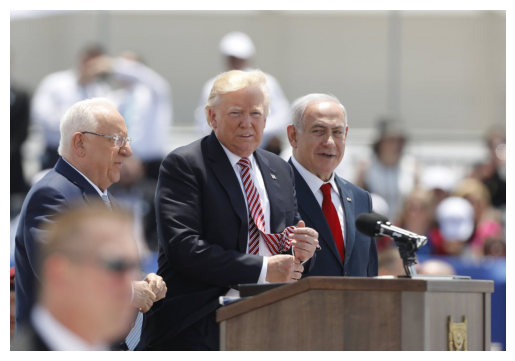

In [362]:
show_image(df_train, 4)

In [363]:
def show_deepface_represent(index, df):
    img_path = os.path.join(findingemo_dir, df.loc[index, 'image_path'])
    print("Image path:", img_path)
    embedding = DeepFace.represent(img_path, detector_backend='retinaface', enforce_detection=False)
    print("Embedding shape:", np.array(embedding).shape)
    print("Embedding:", embedding)
    return embedding

In [364]:
embedding = show_deepface_represent(4, df_train)

Image path: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images\Run_2/Pain teenagers rally/GF36ZVIIE5RV4RXMLC6PVLBU5Q.jpg
Embedding shape: (4,)
Embedding: [{'embedding': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00207375726151123, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005560215762871957, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03775412652934648, 0.0, 0.0, 0.0, 0.0, 0.0035319313290606506, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.008232107594473478, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09321908777377788, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03518313232008257, 0.0, 0.0, 0.0, 0.0, 0.07723346536541034, 0.0, 0.0, 0.10803958673106998, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.975604189309208e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.054653125779284294, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09271380694011672, 0.0,

In [365]:
def show_deepface_analyze(index, df):
    img_path = os.path.join(findingemo_dir, df.loc[index, 'image_path'])
    objs = DeepFace.analyze(img_path, actions = ['emotion'], enforce_detection=False, detector_backend = 'retinaface')
    # Load image (ensure it's in RGB)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Create a figure with subplots (1 row per face)
    n_faces = len(objs)
    fig, axes = plt.subplots(n_faces, 2, figsize=(5, 2 * n_faces))

    if n_faces == 1:
        axes = np.expand_dims(axes, axis=0)  # Handle single face case

    for i, face_obj in enumerate(objs):
        region = face_obj["region"]
        x, y, w, h = region["x"], region["y"], region["w"], region["h"]
        face_crop = img[y:y+h, x:x+w]

        # -------- FACE PANEL --------
        dom_emotion = face_obj.get("dominant_emotion", "?")

        title = f"Face {i+1} | {dom_emotion}"
        axes[i, 0].imshow(face_crop)
        axes[i, 0].set_title(title, fontsize=11)
        axes[i, 0].axis("off")

        # -------- EMOTION DISTRIBUTION --------
        emotions = face_obj["emotion"]
        labels_e = list(emotions.keys())
        values_e = np.array(list(emotions.values()))
        values_e = 100 * values_e / np.sum(values_e)
        axes[i, 1].barh(labels_e, values_e, color="skyblue")
        axes[i, 1].invert_yaxis()
        axes[i, 1].set_xlim(0, 100)
        axes[i, 1].set_title("Emotion (%)")

    plt.tight_layout()
    plt.show()


In [366]:
scene_processor = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load pretrained Places365 ResNet18
scene_model = models.resnet18(num_classes=365)
weights_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
checkpoint = torch.hub.load_state_dict_from_url(weights_url, map_location="cpu")
state_dict = {k.replace("module.", ""): v for k, v in checkpoint["state_dict"].items()}
scene_model.load_state_dict(state_dict)

print("Loaded pretrained models")

Loaded pretrained models


In [367]:
scene_model.to(device)
scene_model.eval()

print("Moved models to device and set to eval mode")

Moved models to device and set to eval mode


In [368]:
# Freeze ResNet backbone, keep fc trainable
for param in scene_model.parameters():
    param.requires_grad = False

In [369]:
df.head()
# get different emotions and the length of the different emotions
emotions = df['emotion'].unique().tolist()
print("Emotions:", emotions)
num_emotions = len(emotions)
print("Number of emotions:", num_emotions)

Emotions: ['Trust', 'Interest', 'Apprehension', 'Anticipation', 'Anger', 'Joy', 'Fear', 'Grief', 'Serenity', 'Vigilance', 'Boredom', 'Ecstasy', 'Admiration', 'Acceptance', 'Sadness', 'Rage', 'Annoyance', 'Terror', 'Amazement', 'Surprise', 'Pensiveness', 'Loathing', 'Distraction', 'Disgust']
Number of emotions: 24


In [370]:
class FaceEmotionAdapter(nn.Module):
    def __init__(self, in_dim=4096, hidden_dim=256, out_dim=24):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)
        self.out_dim = out_dim

    def forward(self, x):
        # detect dummy embeddings (sum of abs values == 0)
        mask = (x.abs().sum(dim=1) == 0)
        h = F.relu(self.fc1(x))
        probs = F.softmax(self.fc2(h), dim=1)
        # create uniform distribution for dummy rows
        uniform = torch.ones_like(probs) / self.out_dim
        # replace dummy rows with uniform distribution
        probs[mask] = uniform[mask]
        return probs
    
face_emotion_adapter = FaceEmotionAdapter()
face_emotion_adapter.to(device)
face_emotion_adapter.train()
face_emotion_adapter_network = Network(face_emotion_adapter, "face_emotion_adapter", batching=True)
face_emotion_adapter_network.optimizer = torch.optim.Adam(face_emotion_adapter.parameters(), lr=lr_faces)

In [371]:
class MappedSceneModel(nn.Module):
    def __init__(self, model, map_365_to_13 = map_365_to_13):
        super().__init__()
        self.model = model
        self.register_buffer("map_365_to_13", map_365_to_13.clone().float())

    def forward(self, x):
        device = next(self.model.parameters()).device
        x = x.to(device)
        logits_365 = self.model(x)
        probs_365 = torch.softmax(logits_365, dim=1)
        probs_13 = torch.matmul(probs_365, self.map_365_to_13)
        return probs_13
    
mapped_scene_model = MappedSceneModel(scene_model)
mapped_scene_model.to(device)
scene_network = Network(mapped_scene_model, "scene_model", batching = True)
scene_network.optimizer = torch.optim.Adam(mapped_scene_model.parameters(), lr=lr_scene)

In [372]:
def display_tensor_as_image(tensor):
    tensor = tensor.squeeze(0)
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    array = tensor.permute(1, 2, 0).numpy()
    plt.imshow(array)
    plt.axis('off')
    plt.show()

In [373]:
if training_size is not None:
    df_train = df_train[:training_size]

In [374]:
class Scene(object):
    def __init__(self, dataframe, subset):
        self.subset = subset
        self.dataframe = dataframe

    def __getitem__(self, i):
        index = int(i[0]) if isinstance(i, (tuple, list)) else int(i)
        img_path = os.path.join(findingemo_dir, self.dataframe.loc[index, 'image_path'])
        image = Image.open(img_path).convert('RGB')
        return scene_processor(image)

In [375]:
scene_train = Scene(df_train, "train")
scene_test = Scene(df_test, "test")

In [381]:
class Faces(object):
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        # Expect i = (sample_id, face_id)
        sample_id, face_id = i
        
        img_path = os.path.join(findingemo_dir, self.df.loc[sample_id, 'image_path'])
        represent = DeepFace.represent(img_path, detector_backend='retinaface', enforce_detection=False)
        facial_area = [x['facial_area'] for x in represent]
        # sort facial areas by size (w*h) descending
        facial_area_sizes = [area['w'] * area['h'] for area in facial_area]
        facial_area_sorted_indices = np.argsort(facial_area_sizes)[::-1]
        embedding = [x['embedding'] for x in represent]
        embedding = [embedding[i] for i in facial_area_sorted_indices]
        print(f"Sample ID: {sample_id}, Face ID: {face_id}, Total Faces: {len(embedding)}")
        if face_id >= len(embedding):
            # If the requested face_id does not exist, return a zero embedding
            return np.zeros((4096,))

        return np.array(embedding[face_id])


In [382]:
faces_train = Faces(df_train)
faces_test = Faces(df_test)

In [390]:
x = faces_train[(40,11)]
x.shape

Sample ID: 40, Face ID: 11, Total Faces: 11


(4096,)

In [391]:
# pass the tensor through the face_emotion_adapter
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)
probs = face_emotion_adapter(x_tensor)
print(probs)

tensor([[0.0417, 0.0417, 0.0417, 0.0417, 0.0417, 0.0417, 0.0417, 0.0417, 0.0417,
         0.0417, 0.0417, 0.0417, 0.0417, 0.0417, 0.0417, 0.0417, 0.0417, 0.0417,
         0.0417, 0.0417, 0.0417, 0.0417, 0.0417, 0.0417]], device='cuda:0',
       grad_fn=<IndexPutBackward0>)


In [295]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,Trust,"BodyLanguage,FacialExpression",0
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,Interest,FacialExpression,0
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,Interest,BodyLanguage,3
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,Interest,"BodyLanguage,FacialExpression",4
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,Apprehension,ConflictCtxtPerson,0


In [ ]:
class FindingEmoDataset(Dataset):
    def __init__(self, dataframe, subset):
        super(FindingEmoDataset, self).__init__()
        self.dataframe = dataframe
        self.subset = subset

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        item = self.dataframe.iloc[idx]
        return item
        
    def to_query(self, i):
        valence = self.dataframe.loc[i, 'valence']
        arousal = self.dataframe.loc[i, 'arousal']
        emotion = self.dataframe.loc[i, 'emotion']

In [38]:
train_dataset = FindingEmoDataset(df_train, "train")
test_dataset = FindingEmoDataset(df_test, "test")
loader = DataLoader(train_dataset, batch_size)

In [39]:
def test_query_face(i, subset, face, model):
    sub_images = [Term(f"face_{x}") for x in range(3)]
    images = [
        Term("tensor", Term(f"{subset}_faces", Constant(i), Constant(x)))
        for x in range(3)
    ]

    sub = {sub_images[x]: images[x] for x in range(3)}

    face_tensor = torch.load(os.path.join(findingemo_dir, "faces_tensors", subset, f"{i}_{face}.pt"))

    display_tensor_as_image(face_tensor)

    query = Query(
        query=Term(f"face_emotion{face}", 
                    list2term(sub_images),
                    Var("Emotion")),
        substitution=sub
    )

    results = model.solve([query])
    result = results[0].result

    for key, value in sorted(result.items(), key=lambda kv: kv[1].item(), reverse=True):
        emotion = key.args[1]
        prob = value.item()
        print(f"{emotion}: {prob:.4f}")

In [40]:
model = Model(
    os.path.join(prolog_dir, "model3.pl"),
    [scene_network, face_network]
)
model.set_engine(ExactEngine(model), cache=False)
model.optimizer = SGD(model, param_lr=lr_model)

model.add_tensor_source("train_faces", faces_train)
model.add_tensor_source("train_scene", scene_train)
model.add_tensor_source("test_faces", faces_test)
model.add_tensor_source("test_scene", scene_test)

Scene index: 1256


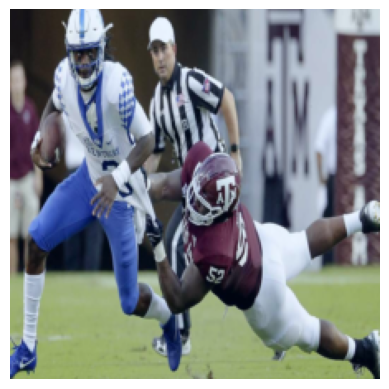

Mapped results: 
------------
sports_and_entertainment: 0.9998
rural_or_recreational_area: 0.0001
indoor_institutional: 0.0000
natural_landscape: 0.0000
religious_or_historical_site: 0.0000
urban_outdoor: 0.0000
indoor_commercial: 0.0000
industrial_facility: 0.0000
indoor_residential: 0.0000
aquatic_environment: 0.0000
cultural_space: 0.0000
transport_infrastructure: 0.0000
cold_environment: 0.0000

Original results
------------
football_field (-> sports_and_entertainment): 0.6332
stadium_football (-> sports_and_entertainment): 0.3344
athletic_field_outdoor (-> sports_and_entertainment): 0.0170
soccer_field (-> sports_and_entertainment): 0.0087
stadium_soccer (-> sports_and_entertainment): 0.0059
baseball_field (-> sports_and_entertainment): 0.0003
racecourse (-> sports_and_entertainment): 0.0002
stadium_baseball (-> sports_and_entertainment): 0.0001
golf_course (-> rural_or_recreational_area): 0.0001
campus (-> rural_or_recreational_area): 0.0000


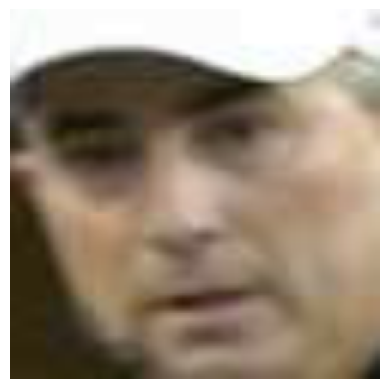

fear: 0.3971
surprise: 0.3313
anger: 0.2611
sadness: 0.0047
disgust: 0.0047
joy: 0.0011


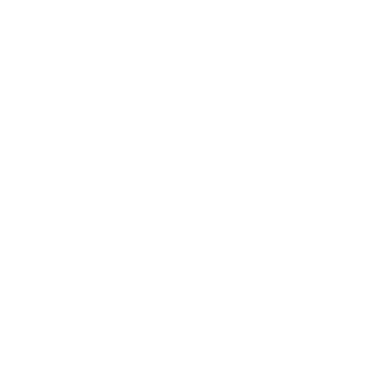

sadness: 0.8048
surprise: 0.0560
joy: 0.0543
anger: 0.0440
fear: 0.0297
disgust: 0.0113


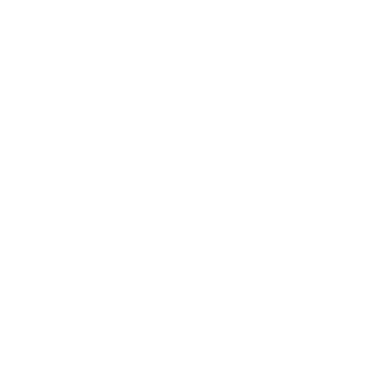

sadness: 0.8048
surprise: 0.0560
joy: 0.0543
anger: 0.0440
fear: 0.0297
disgust: 0.0113


In [41]:
def test_query(i, sceneds, subset, model):
    print("Scene index:", i)
    scene_tensor = sceneds[i]

    display_tensor_as_image(scene_tensor)

    query = Query(
        query=Term(f"scene_context", 
                    Term("tensor", Term(f"{subset}_scene", Constant(i))),
                    Var("Context")),
                    substitution={}
    )

    results = model.solve([query])
    result = results[0].result

    print("Mapped results: ")
    print("------------")
    for key, value in sorted(result.items(), key=lambda kv: kv[1].item(), reverse=True):
        context = key.args[1]
        prob = value.item()
        print(f"{context}: {prob:.4f}")
    print("")
    print("Original results")
    print("------------")
    scene_tensor = scene_tensor.unsqueeze(0).to(device)
    logits365 = scene_model(scene_tensor)
    probs365 = torch.softmax(logits365, dim=1)

    for i in torch.topk(probs365, 10).indices[0]:
        category = scene_categories[i]
        prob = probs365[0, i].item()
        print(f"{category} (-> {places365_to_13categories[category]}): {prob:.4f}")

random_idx = np.random.randint(0, len(df_train))

test_query(random_idx, scene_train, "train", model)

test_query_face(random_idx, "train", 0, model)
test_query_face(random_idx, "train", 1, model)
test_query_face(random_idx, "train", 2, model)

In [42]:
train_obj = train_model(
    model,
    loader,
    epochs,
    loss_function_name="cross_entropy",
    log_iter= 50,
    # test_iter=5 * len(test_dataset) // batch_size,
    # test=lambda x: [
    #     ("Accuracy", get_confusion_matrix(model, test_dataset).accuracy())
    # ],
    infoloss=0.5,
)  # ,
# Cm based on max prediction
# cm = get_confusion_matrix(model, test_dataset)

Training  for 2 epoch(s)
Epoch 1


c:\Users\jarne\miniconda3\envs\dpl_base\lib\site-packages\deepproblog\semiring\graph_semiring.py:77: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:837.)
  return -self.eps <= float(a) <= self.eps


Iteration:  50 	s:25.9008 	Average Loss:  1.6831848052144052
0.3439219699880082	0.20520521845146558	0.17850429417266656	0.2723685173878597


KeyboardInterrupt: 

In [ ]:
# save the model under model directory
model_directory = os.path.join(base_dir, "code", "models")

dpl_state_path = os.path.join(model_directory, "deepproblog_state.pth")
model.save_state(dpl_state_path)

In [ ]:
prolog_path = os.path.join(prolog_dir, "model3.pl")
model = Model(prolog_path, [scene_network, face_network])
model.set_engine(ExactEngine(model), cache=False)

dpl_state_path = os.path.join(model_directory, "deepproblog_state.pth")
model.load_state(dpl_state_path)

# Ready for inference or continued training
model.add_tensor_source("train_faces", faces_train)
model.add_tensor_source("train_scene", scene_train)
model.add_tensor_source("test_faces", faces_test)
model.add_tensor_source("test_scene", scene_test)

face_model_truncated.eval()
mapped_scene_model.eval()

TruncatedSceneModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [ ]:
cf = get_confusion_matrix(model, test_dataset)

c:\Users\jarne\miniconda3\envs\deepproblog\lib\site-packages\deepproblog\semiring\graph_semiring.py:77: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  return -self.eps <= float(a) <= self.eps


KeyboardInterrupt: 

In [ ]:
# # For every training sample, get the best category prediction and the emo8 label. I want to know for each scene category, how many samples of each emo8 label exist.
# scene_category_counts = {cat: {emo: 0 for emo in basic_6_emotions} for cat in categories_13}

# for i in range(len(df_train)):
#     if i % 500 == 0:
#         print(f"Processing training sample {i+1}/{len(df_train)}")
#     scene_tensor = scene_train[i].unsqueeze(0).to(device)
#     logits365 = scene_model(scene_tensor)
#     probs365 = torch.softmax(logits365, dim=1)
#     top_idx = torch.argmax(probs365, dim=1).item()
#     top_category = scene_categories[top_idx]
#     coarse_category = places365_to_13categories[top_category]
#     emo6_label = df_train.loc[i, "emotion_6"]
#     scene_category_counts[coarse_category][emo6_label] += 1

In [ ]:
# # calculate the prob of each emo8 label per scene category
# scene_category_probs = {}
# for scene, counts in scene_category_counts.items():
#     total = sum(counts.values())
#     scene_category_probs[scene] = {emo: count / total for emo, count in counts.items()}
# scene_category_probs

In [ ]:
# # Save that scene_category_probs dictionary to a json file
# import json
# with open(os.path.join(prolog_dir, "scene_category_emo8_probs.json"), "w") as f:
#     json.dump(scene_category_probs, f, indent=4)

In [ ]:
# # Write to model3.pl file the prior probabilities for each scene category
# with open(os.path.join(prolog_dir, "model3.pl"), "a") as f:
#     for scene, probs in scene_category_probs.items():
#         for emo, prob in probs.items():
#             f.write(f"{prob:.2f}::context_to_emotion({scene}, {emo}).\n")